In [2]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimSun"]
plt.rcParams['axes.unicode_minus'] = False

In [3]:
def calc_cover_intervals_multi(
    f_speeds, f_dirs, t_releases, t_bursts,
    f_positions=None,
    smoke_v0=-3, g=9.80665,
    missile_v=300,
    if_debug=False,
    missile_start=np.array([20000, 0, 2000], dtype=np.float32),
    missile_target=np.array([0, 0, 0], dtype=np.float32),
    smoke_radius=10,
    time_window=(0, 40),  # seconds
    time_steps=40001
):
    """
    计算三个无人机的烟幕弹对导弹-真目标路径的总有效遮蔽时间（全局时间）。
    只要任意一个烟幕在某时刻遮蔽路径，即算有效遮蔽。

    参数:
        f_speeds: [v1, v2, v3] 无人机速度(m/s)
        f_dirs: [dir1, dir2, dir3] 运动方向（弧度，xy平面，z=0）
        t_releases: [t1, t2, t3] 投放时间(s)
        t_bursts: [tb1, tb2, tb3] 投放后多久起爆(s)
        f_positions: [p1, p2, p3] 初始位置(3x3数组)，默认见下
        其它参数同单机版本
    返回:
        总有效遮蔽时间（秒）
    """
    # 默认无人机初始位置
    if f_positions is None:
        f_positions = [
            np.array([17800, 0, 1800], dtype=np.float32),
            np.array([12000, 1400, 1400], dtype=np.float32),
            np.array([6000, -3000, 700], dtype=np.float32)
        ]
    # 计算导弹方向
    missile_dir = (missile_target - missile_start) / np.linalg.norm(missile_target - missile_start)
    # 时间轴
    t_list = np.linspace(time_window[0], time_window[1], time_steps, dtype=np.float32)
    # 导弹位置（从初始点出发，不考虑释放时间）
    missile_positions = missile_start[:, np.newaxis] + missile_v * t_list * missile_dir[:, np.newaxis]
    missile_pos = missile_positions.T  # (N,3)
    target = np.array([0,200,5], dtype=np.float32)

    # 烟幕球心轨迹（3个无人机）
    smoke_positions_all = []
    for i in range(len(f_positions)):
        # 无人机运动方向向量
        f_dir_vec = np.array([np.cos(f_dirs[i]), np.sin(f_dirs[i]), 0], dtype=np.float32)
        # 干扰弹在投放点 + 后续水平位移
        f_release = f_positions[i] + f_speeds[i] * (t_releases[i] + t_bursts[i]) * f_dir_vec
        # 起爆点
        smoke_burst = np.array([
            f_release[0],
            f_release[1],
            f_release[2] + (-0.5) * g * t_bursts[i]**2
        ], dtype=np.float32)
        # 烟幕球心轨迹
        smoke_z = smoke_burst[2] + smoke_v0 * t_list
        smoke_positions = np.stack([
            np.full_like(t_list, smoke_burst[0]),
            np.full_like(t_list, smoke_burst[1]),
            np.where(t_list >= t_bursts[i], smoke_z, 1e8)  # 起爆前位置无效
        ], axis=0)
        smoke_positions_all.append(smoke_positions.T)  # (N,3)

    # 遮蔽判定（只要任意一个烟幕有效即可）
    in_smoke_total = np.zeros_like(t_list, dtype=bool)
    ab = target - missile_pos         # (N,3)
    ab_norm2 = np.sum(ab**2, axis=1)  # (N,)
    for smoke_pos in smoke_positions_all:
        ap = smoke_pos - missile_pos      # (N,3)
        s = np.sum(ap * ab, axis=1) / ab_norm2
        closest = missile_pos + ab * s[:, None]  # (N,3)
        dist = np.linalg.norm(smoke_pos - closest, axis=1)  # (N,)
        in_smoke = dist <= smoke_radius
        if if_debug:
            dt = t_list[1] - t_list[0]
            if np.any(in_smoke == 1):
                print(f"Smoke in missile:{np.where(in_smoke == True)[0][0] * dt:.2f}， last:{np.where(in_smoke == True)[0][-1] * dt:.2f}")
            else:
                print(f"Smoke never in missile")

        in_smoke_total = in_smoke_total | in_smoke  # 只要任意一个烟幕有效

    # 计算总有效遮蔽时间
    dt = t_list[1] - t_list[0]
    total_cover_time = np.sum(in_smoke_total) * dt
    return total_cover_time

In [4]:
from sko.PSO import PSO

# PSO优化目标函数（与GA类似，返回负值以最大化遮蔽时间）
def pso_objective(x):
    # x: [v1, v2, v3, dir1, dir2, dir3, t1, t2, t3, tb1, tb2, tb3]
    f_speeds = x[0:3]
    f_dirs = x[3:6]
    t_releases = x[6:9]
    t_bursts = x[9:12]
    return -calc_cover_intervals_multi(
        f_speeds=f_speeds,
        f_dirs=f_dirs,
        t_releases=t_releases,
        t_bursts=t_bursts
    )

# 参数范围
lb = [130, 70, 70,   0, 0, 0,   0, 0, 30,   0, 0, 0]
ub = [140, 140, 140,   2*np.pi, 2*np.pi, 2*np.pi,   1, 30, 50,   1, 10, 10]

# PSO实例化
pso = PSO(
    func=pso_objective,
    dim=12,
    pop=70,
    max_iter=160,
    lb=lb,
    ub=ub,
    w=0.8,
    c1=2,
    c2=2,

)

pso.run()


第一架无人机的参数: [1.40000000e+02 1.18579320e-01 7.05350441e-01 0.00000000e+00]
第二架无人机参数:[140.           4.38276258   0.75659631   0.        ]
第三架无人机参数:[70.          1.35286875 45.7024054   0.        ]
最大遮蔽时间: 10.946000519907102
Smoke in missile:0.86， last:5.68
Smoke never in missile
Smoke in missile:6.02， last:12.15


10.946000519907102

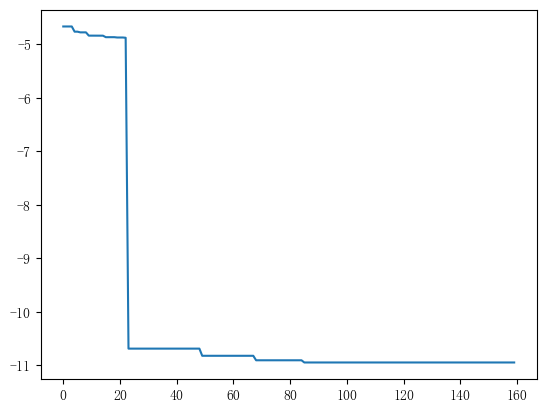

In [5]:
best_x, best_y = pso.gbest_x, pso.gbest_y
plt.plot(pso.gbest_y_hist)

print(f"第一架无人机的参数: {best_x[0:12:3]}\n第二架无人机参数:{best_x[1:12:3]}\n第三架无人机参数:{best_x[2:12:3]}")
print(f"最大遮蔽时间: {-best_y}")
calc_cover_intervals_multi(
    f_speeds=best_x[0:3],
    f_dirs=best_x[3:6],
    t_releases=best_x[6:9],
    t_bursts=best_x[9:12],
    if_debug=True
)